In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image, display
import time

# Initialization

In [2]:
def init_binary_mesh(n, d = 0.3):

    mask = np.random.uniform(low = 0, high = 1, size = (n, n))
    arr = mask < d

    arr = arr.astype(int)

    return arr

# Auxiliary functions

In [3]:
def cell_energy(arr, row, col, energy_mask):
    n = arr.shape[0]
    k = energy_mask.shape[0]
    shift =  k // 2
    energy = 0 

    cell_color = arr[row][col]

    for i in range(-shift, shift + 1):
        for j in range(-shift, shift + 1):
            if -1 < row + i < n and -1 < col + j < n:
                neighbour_color = arr[row + i][col + j]

                if neighbour_color == cell_color:
                    energy -= energy_mask[i + shift][j + shift]

                else:
                    energy += energy_mask[i + shift][j + shift]

    return energy

In [4]:
def batch_energy(arr, row, col, energy_mask):
    n = arr.shape[0]
    k = energy_mask.shape[0]
    shift = k // 2
    energy = 0

    for i in range(-shift, shift + 1):
        for j in range(-shift, shift + 1):
            if -1 < row + i < n and -1 < col + j < n:
                energy += cell_energy(arr, row + i, col + j, energy_mask)
    
    return energy

In [5]:
def mesh_energy(arr, energy_mask):
    n = arr.shape[0]
    total_energy = 0

    for row in range(n):
        for col in range(n):
            total_energy += cell_energy(arr, row, col, energy_mask)
    
    return total_energy

In [6]:
def modify_solution(arr, energy_mask):
    n = arr.shape[0]

    u1, v1 = np.random.choice(n, 2)
    u2, v2 = np.random.choice(n, 2)

    neigbouring_energy = batch_energy(arr, u1, v1, energy_mask) + batch_energy(arr, u2, v2, energy_mask)

    arr[u1][v1], arr[u2][v2] = arr[u2][v2], arr[u1][v1]

    new_neighbouring_energy = batch_energy(arr, u1, v1, energy_mask) + batch_energy(arr, u2, v2, energy_mask)

    return new_neighbouring_energy - neigbouring_energy, u1, v1, u2, v2

In [7]:
def revert_modify(arr, u1, v1, u2, v2):
    arr[u1][v1], arr[u2][v2] = arr[u2][v2], arr[u1][v1]

In [8]:
def accept_updated_solution(T, dE):
    if dE < 0:
        return True
    
    else:
        p = np.exp(-dE / T)
        r = np.random.uniform(low = 0, high = 1)

        if r < p:
            return True
        else:
            return False

# Visualization

In [10]:
def vis_binary_map(binary_map):
    plt.imshow(binary_map, cmap='binary', interpolation='nearest')

    plt.title('Binary Mesh')
    plt.xlabel('X')
    plt.ylabel('Y')

In [11]:
def save_frame_to_gif(binary_map):
    vis_binary_map(binary_map)
    
    plt.savefig("./vis/img.png",
        transparent = False,
        facecolor = 'white'
    )

    plt.close()

In [12]:
def update_vis_gif(binary_map, frames):
    save_frame_to_gif(binary_map)

    image = imageio.v2.imread("./vis/img.png")
    frames.append(image)

In [13]:
def draw_cost_timeline(logs):
    iterations = list(range(len(logs)))

    plt.plot(iterations, logs)

    plt.show()

In [45]:
def display_gif(gif_path = './vis/bit_map.gif'):
    display(Image(filename = gif_path))

# Simulation algorithm

In [28]:
def simulation(arr, energy_mask, t_func = lambda x: 0.999 * x, iter_max_no = 10 ** 5, T = 100, log_step = 10 ** 2, eps = 10 ** -6):
    energy = mesh_energy(arr, energy_mask)
    logs = []
    historically_best_energy = energy
    historically_best_mask = np.copy(arr)

    for i in range(iter_max_no):
        dE, u1, v1, u2, v2 = modify_solution(arr, energy_mask)

        if accept_updated_solution(T, dE):
            energy = energy + dE
            if energy < historically_best_energy:
                historically_best_energy, historically_best_mask = energy, np.copy(arr)
        else:
            revert_modify(arr, u1, v1, u2, v2)

        if i % log_step == 0:
            logs.append(energy)

        T = t_func(T)

        if T < eps:
            break
    
    if energy < historically_best_energy:
        historically_best_energy, historically_best_mask = energy, arr

    return historically_best_energy, historically_best_mask, logs

# Simulation with visualization

In [48]:
def vis_simulation(arr, energy_mask, t_func = lambda x: 0.999 * x, iter_max_no = 10 ** 5, T = 100, vis_step = 10 ** 2, gif_path = './vis/bit_map.gif', eps = 10 ** -6):
    frames = []
    logs = []
    energy = mesh_energy(arr, energy_mask)
    historically_best_energy = energy
    historically_best_mask = np.copy(arr)

    for i in range(iter_max_no):
        dE, u1, v1, u2, v2 = modify_solution(arr, energy_mask)

        if accept_updated_solution(T, dE):
            energy = energy + dE
            if energy < historically_best_energy:
                historically_best_energy, historically_best_mask = energy, np.copy(arr)
        else:
            revert_modify(arr, u1, v1, u2, v2)

        if i % vis_step == 0:
            update_vis_gif(arr, frames)
            logs.append(energy)

        T = t_func(T)

        if T < eps:
            break

    if energy < historically_best_energy:
        historically_best_energy, historically_best_mask = energy, arr

    update_vis_gif(historically_best_mask, frames)
    imageio.mimsave(gif_path, ims = frames, fps = 30, loop = 0)
        
    return historically_best_energy, historically_best_mask, logs

# Examples

In [43]:
energy_masks = [
    np.array([
        [-1, 1, -1],
        [1, 0, 1],
        [-1, 1, -1]
    ]),
    np.array([
        [1, 1, 1, 1, 1],
        [1, -1, -1, -1, 1],
        [1, -1, 0, -1, 1],
        [1, -1, -1, -1, 1],
        [1, 1, 1, 1, 1]
    ]),
    np.array([
        [3, -3, 3],
        [-1, 0, -1],
        [1, -1, 1]
    ]),
    np.array([
        [1, 0, -1],
        [0, 1, 0],
        [-1, 0, 1]
    ]),
    np.array([
        [-1, -1, 1, -1, -1],
        [-1, 1, 1, 1, -1],
        [1, 1, 0, 1, 1],
        [-1, 1, 1, 1, -1],
        [-1, -1, 1, -1, -1]
    ])
]

In [44]:
n = 20
d = 0.3
t_func = lambda x: x * 0.999

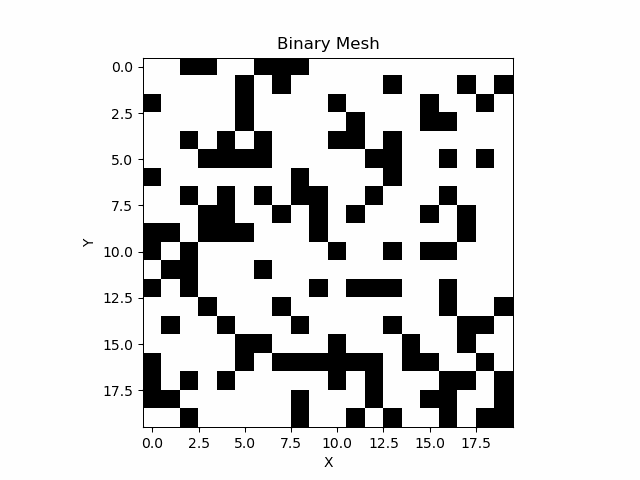

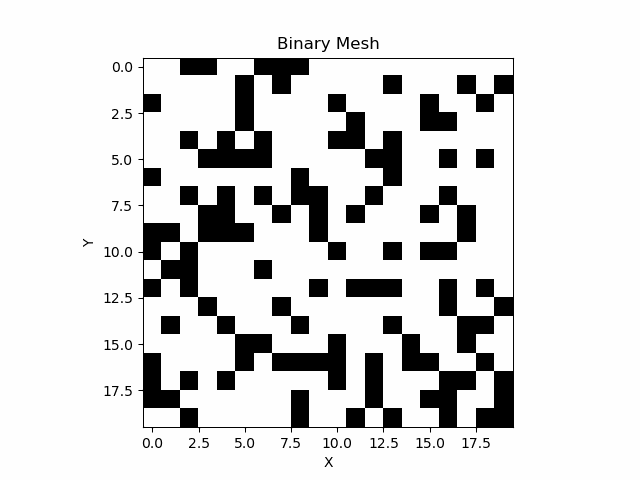

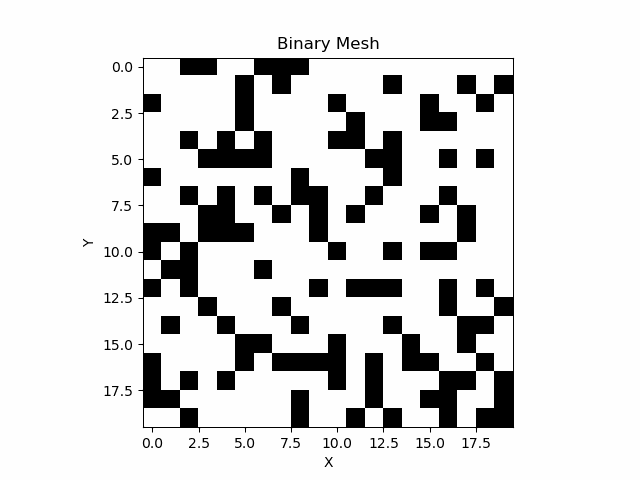

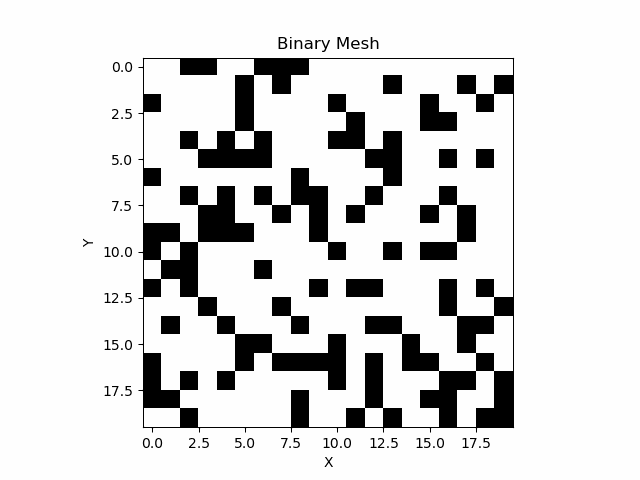

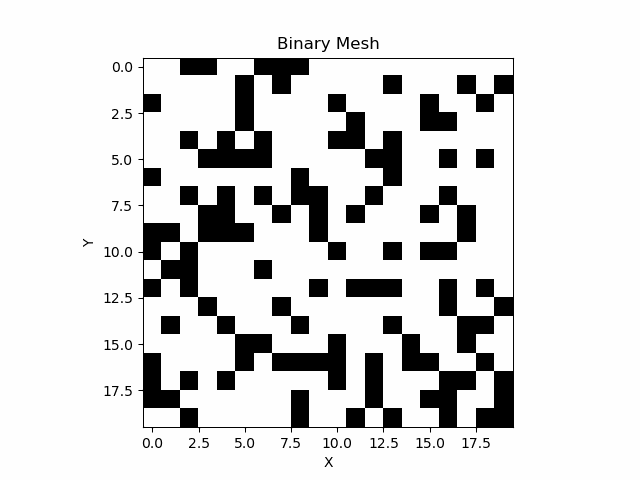

In [46]:
arr_buff = init_binary_mesh(n, d)
for energy_mask in energy_masks:
    arr = np.copy(arr_buff)
    vis_simulation(arr, energy_mask = energy_mask, t_func = t_func)
    display_gif()

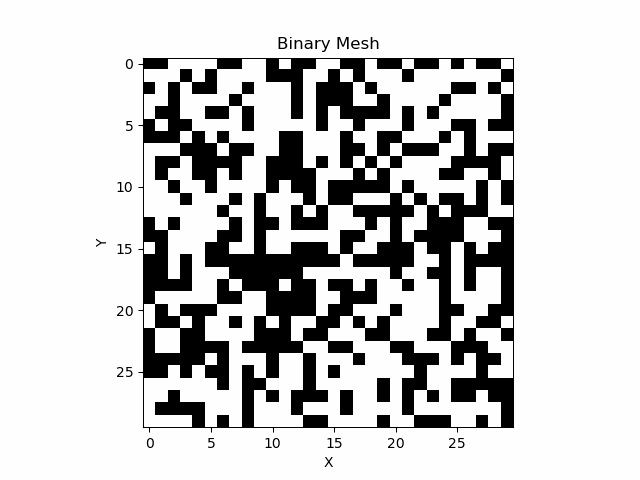

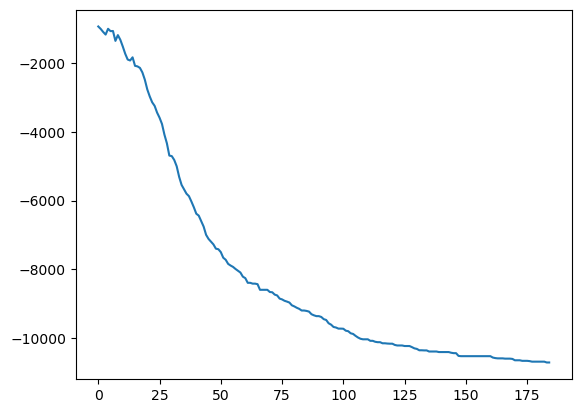

In [52]:
energy_mask = np.array([
        [1, 1, 1, 1, 1],
        [1, -1, -1, -1, -1],
        [1, 1, 1, -1, -1],
        [1, -1, -1, -1, -1],
        [1, 1, 1, 1, 1]
    ])

n = 30
d = 0.45
t_func = lambda x: x * 0.999
arr = init_binary_mesh(n, d)

_, _, logs = vis_simulation(arr, energy_mask, t_func)
display_gif()
draw_cost_timeline(logs)

# Benchmark

In [30]:
n_values = [
    10,
    20,
    30,
    50
]

In [31]:
t_functions = [
    lambda x: 0.999 * x,
    lambda x: 0.99 * x,
    lambda x: 0.95 * x,
    lambda x: x - 0.01,
]

In [32]:
d_values = [
    0.1,
    0.3,
    0.4
]

In [33]:
energy_masks = [
    np.array([
        [-1, 1, -1],
        [1, 0, 1],
        [-1, 1, -1]
    ]),
    np.array([
        [1, 1, 1, 1, 1],
        [1, -1, -1, -1, 1],
        [1, -1, 0, -1, 1],
        [1, -1, -1, -1, 1],
        [1, 1, 1, 1, 1]
    ]),
    np.array([
        [3, -3, 3],
        [-1, 0, -1],
        [1, -1, 1]
    ]),
    np.array([
        [1, 0, -1],
        [0, 1, 0],
        [-1, 0, 1]
    ]),
    np.array([
        [-1, -1, 1, -1, -1],
        [-1, 1, 1, 1, -1],
        [1, 1, 0, 1, 1],
        [-1, 1, 1, 1, -1],
        [-1, -1, 1, -1, -1]
    ])
]

In [42]:
for energy_mask in energy_masks:
    print("Energy mask: ")
    print(energy_mask)
    for n in n_values:
        print("\tn: {n}".format(n = n))
        for d in d_values:
            print("\t\td: {d}".format(d = d))
            arr_buff = init_binary_mesh(n, d)
            for t_func in t_functions:
                arr = np.copy(arr_buff)
                time1 = time.time()
                historically_best_energy, _, _ = simulation(arr, energy_mask = energy_mask, t_func = t_func)
                time2 = time.time()

                print("\t\t\tTime: {time_diff}, energy: {energy}".format(time_diff = time2 - time1, energy = historically_best_energy))

Energy mask: 
[[-1  1 -1]
 [ 1  0  1]
 [-1  1 -1]]
	n: 10
		d: 0.1
			Time: 11.827155828475952, energy: -104
			Time: 1.0642917156219482, energy: -102
			Time: 0.22597694396972656, energy: -80
			Time: 6.104959011077881, energy: -164
		d: 0.3
			Time: 11.24461579322815, energy: -338
			Time: 1.1060030460357666, energy: -166
			Time: 0.20199799537658691, energy: -168
			Time: 5.845402717590332, energy: -334
		d: 0.4
			Time: 10.951173067092896, energy: -606
			Time: 1.0799992084503174, energy: -246
			Time: 0.18100237846374512, energy: -230
			Time: 5.410884141921997, energy: -292
	n: 20
		d: 0.1
			Time: 11.82688570022583, energy: -372
			Time: 1.2889611721038818, energy: -226
			Time: 0.3563864231109619, energy: -156
			Time: 7.352266788482666, energy: -280
		d: 0.3
			Time: 13.367655992507935, energy: -920
			Time: 2.160090208053589, energy: -620
			Time: 0.3430006504058838, energy: -360
			Time: 8.189333438873291, energy: -636
		d: 0.4
			Time: 12.882772207260132, energy: -1182
			T

# Summary

Zależnie od zdefiniowanej "funkcji" energii (energy_mask) układ bitów na mapie znacząco się różni. Kształty uzyskane dla każdego układu sąsiedztwa, można zaobserwować na wyżej przedstawionych wizualizacjach. Stany sąsiednie generowane są za pomocą zamiany dwóch wartości bitów w każdym kroku symulacji. Wartość energii została porównana pomiędzy różnymi funkcjami spadku temperatury. Dla każdego układu najlepsze rezultaty wykazuje funkcja spadku temperatury: $T_{i + 1} = 0.9999 * T_{i}$, jest to jednak spowodowane tym, że funkcja ta zdecydowanie później niż pozostałe uzyska temperaturę bliską zeru. W związku z tym, czas działania algorytmu dla tej funkcji jest znacząco wyższy niż dla pozostałych funkcji. Jeśli zależy nam na czasie działania algorytmu, obiecujące rezultaty daje funkcja spadku: $T_{i + 1} = 0.99 * T_{i}$, której rezultaty są średnio 1.5 raza gorsze, lecz czas działania jest około $10$ razy krótszy.

Istnieje możliwość definiowania własnych systemów energetycznych. System musi być macierzą nieparzystego rzędu, gdzie środkowy element znacza bit, którego energię obliczamy. Wartość dodatnia oznacza, że bity tego samego koloru co środkowy element się przyciągają, a wartość ujemna oznacza, że bity tego samego koloru co środkowy element się odpychają. Nie trzeba ograniczać się do wartości ${-1, 0, 1}$, można stwierdzić, że pewni sąsiedzi przyciągają lub odpychają się znacznie bardziej niż pozostali.